In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder = '/content/drive/MyDrive/Năm 3/03. NLP/NLP - Đồ án cuối kỳ'

# Thư viện

In [3]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.2 MB/s eta 0:00:00


In [4]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 9.2 MB/s eta 0:00:00


In [5]:
!pip install wikiextractor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 1.8 MB/s eta 0:00:00


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import copy
import gensim
import emoji

from pyvi import ViTokenizer, ViPosTagger
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# Maxent model
from nltk.classify import MaxentClassifier
from nltk.classify.util import accuracy

# Tiền xử lý
(nguồn: https://github.com/hieugiaosu/Vietnamese-Sentiment-Analysis-UIT-VSMEC-DATASET-/blob/main/sentiment.ipynb)


In [7]:
train = pd.read_excel(folder + '/UIT-VSMEC' + '/train_nor_811.xlsx', index_col=0)
# val = pd.read_excel(folder + '/UIT-VSMEC' + '/valid_nor_811.xlsx', index_col=0)
test = pd.read_excel(folder + '/UIT-VSMEC' + '/test_nor_811.xlsx', index_col=0)

In [8]:
train

,Emotion,Sentence
188,Other,cho mình xin bài nhạc tên là gì với ạ
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
825,Other,nhìn mặt héo queo luôn
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
363,Enjoyment,thích thân hình boss rồi nhan 😌


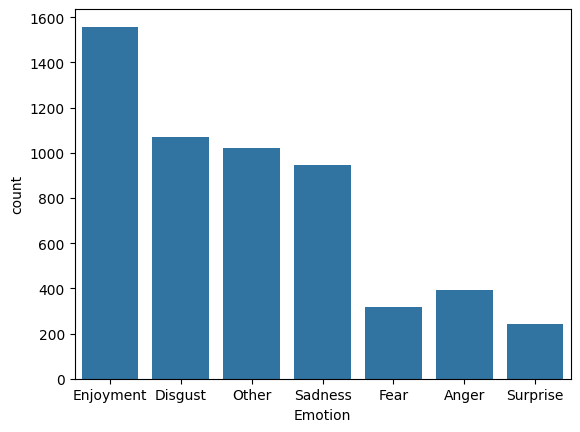

In [9]:
sns.countplot(x='Emotion', data=train, order=test['Emotion'].value_counts().index)
plt.show()

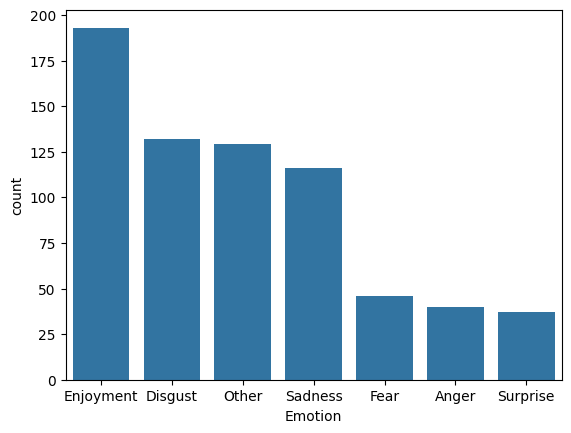

In [10]:
sns.countplot(x='Emotion', data=test, order=test['Emotion'].value_counts().index)
plt.show()

Có thể thấy dữ liệu của tập train và tập test có số nhãn khá mất cân bằng, các nhãn Fear, Anger, Suprise có ít mẫu hơn

In [21]:
stopwords = []
with open(folder + '/vietnamese-stopwords.txt', 'r') as f:
    for line in f:
        stopwords.append(line.strip())
# stopwords

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy',
 'ba',
 'ba ba',
 'ba bản',
 'ba cùng',
 'ba họ',
 'ba ngày',
 'ba ngôi',
 'ba tăng',
 'bao giờ',
 'bao lâu',
 'bao nhiêu',
 'bao nả',
 'bay biến',
 'biết',
 'biết bao',
 'biết bao nhiêu',
 'biết chắc',
 'biết chừng nào',
 'biết mình',
 'biết mấy',
 'biết thế',
 'biết trước',
 'biết việc',
 'biết đâu',
 'biết đâu chừng',
 'biết đâu đấy',
 'biết được',
 'buổi',
 'buổi làm',
 'buổi mới',
 'buổi ngày',
 'buổi sớm',
 'bà',
 'bà ấy',
 'bài',
 'bài bác',
 'bài bỏ',
 'bài cái',
 'bác',
 'bán',
 'bán cấp',
 'bán dạ',
 'bán thế',
 'bây bẩy',
 'bây chừ',
 'bây giờ',
 'bây nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên bị',
 'bên có',
 'bên cạnh',
 'bông',
 'bước',
 'bước khỏi',
 'bước tới',
 'bước đi',
 'bạn',
 'bản',
 'bản bộ',
 'bản riêng',
 'bản thân',
 'bản ý',
 'bất chợt',
 'bất cứ',
 'bất giác',
 'bất kì',
 'bất kể',
 'bất kỳ',
 'bất luận',
 'bất ngờ',
 'bất nhược',
 'bất quá',
 'bất quá chỉ',
 'bất thình l

In [12]:
teencodes = {}
with open(folder + '/teencode4.txt','r') as file:
    file = file.read()
    lines = file.split('\n')
    for line in lines:
        elements = line.split('\t')
        if len(elements) == 2:
            teencodes[elements[0]] = elements[1]
# teencodes

{'ctrai': 'con trai',
 'khôg': 'không',
 'bme': 'bố mẹ',
 'cta': 'chúng ta',
 'mih': 'mình',
 'cmnl': 'con mẹ nó luôn',
 'mqh': 'mối quan hệ',
 'ùi': 'rồi',
 'sem': 'xem',
 'pải': 'phải',
 'đel': 'đéo',
 'cgai': 'con gái',
 'nhữg': 'những',
 'mng': 'mọi người',
 'r': 'rồi',
 'qtam': 'quan tâm',
 'thươg': 'thương',
 'lun': 'luôn',
 'cute': 'dễ thương',
 'kute': 'dễ thương',
 'ưi': 'ơi',
 'kao': 'tao',
 'tau': 'tao',
 'gê': 'ghê',
 'ge': 'ghê',
 'kau': 'tao',
 'rùi': 'rồi',
 'qtâm': 'quan tâm',
 'share': 'chia sẻ',
 'chug': 'chung',
 'vại': 'vậy',
 'trườg': 'trường',
 'hjx': 'hic',
 'hix': 'hic',
 'thoy': 'thôi',
 'oy': 'rồi',
 'đki': 'đăng ký',
 'àk': 'à',
 'qcao': 'quảng cáo',
 'pr': 'quảng cáo',
 'cv': 'công việc',
 'tr': 'trời',
 'vch': 'vãi chưởng',
 'cùg': 'cùng',
 'thjck': 'thích',
 'thjk': 'thích',
 'ktra': 'kiểm tra',
 'cgái': 'con gái',
 'nthe': 'như thế',
 'chúg': 'chúng',
 'tìh': 'tình',
 'phòg': 'phòng',
 'lòg': 'lòng',
 'từg': 'từng',
 'rằg': 'rằng',
 'sốg': 'sống',
 'thuj'

In [13]:
def preprocess_teencodes(sentence):
    for key, value in teencodes.items():
        sentence = re.sub(r'\b{}\b'.format(key), value, sentence)
    return sentence

In [14]:
def preprocess_emoji(sentence):
    emotion_dict = {
        '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
        '(-_-)|(-\.-)':'😐',':v':'_pacman_smile_','(:|;|=)+(\'|`|\")+(\)|\]|>)+':'🥲','(:|;|=)+(\'|`|\")+(\(|\[|<)+':'😢',
        '@@':'😵‍💫','đc':'được','đk':'được','bik':'biết','ngừi':'người','hix':'hic','lm':'làm'
    }
    for key, value in emotion_dict.items():
        sentence = re.sub(key,value,sentence)
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r":(.*?):",r" _\1_ ",sentence)
    sentence = re.sub(r'([!@#$%^&*()_+={}:;"\'<>,?/\|~-])\1+',r'\1',sentence)
    return sentence

In [15]:
def tokenize(sentence):
    start_token = ' _s_ '
    end_token = ' _e_ '
    sentence = sentence.lower()

    # Preprocess Emoji
    sentence = preprocess_emoji(sentence)

    # Preprocess teencodes
    sentence = preprocess_teencodes(sentence)

    sentence = start_token + sentence + end_token
    return ViTokenizer.tokenize(sentence).split()

In [17]:
def remove_stopwords(words):
    new_words = [word for word in words if re.sub("_", " ", word) not in stopwords]
    return new_words

In [20]:
train['Text'] = train['Sentence'].apply(tokenize)
train['Text'] = train['Text'].apply(remove_stopwords)
train

,Emotion,Sentence,Text
188,Other,cho mình xin bài nhạc tên là gì với ạ,"[_s_, nhạc, _e_]"
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,"[_s_, đường, nhà_cụ, cụ, cấm, người_ta, đỗ, .,..."
825,Other,nhìn mặt héo queo luôn,"[_s_, mặt, héo, queo, _e_]"
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,"[_s_, tao, đi, xe_máy, xe, đi, phi_mẹ, quán, n..."
363,Enjoyment,thích thân hình boss rồi nhan 😌,"[_s_, thân_hình, boss, nhan, _relieved_face_, ..."


In [22]:
test['Text'] = test['Sentence'].apply(tokenize)
test['Text'] = test['Text'].apply(remove_stopwords)
test

,Emotion,Sentence,Text
713,Sadness,người ta có bạn bè nhìn vui thật,"[_s_, người_ta, bạn_bè, vui, _e_]"
1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật,"[_s_, nghỉ, viêc, mói, goi, kỷ_luật, _e_]"
1166,Disgust,kinh vãi 😡,"[_s_, kinh, vãi, _enraged_face_, _e_]"
228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,"[_s_, lắm, đi, sợ, đè_bẹp, _slightly_smiling_f..."
1942,Anger,bố không thích nộp đấy mày thích ý kiến không,"[_s_, bố, nộp, đấy, mày, ý_kiến, _e_]"
...,...,...,...
432,Sadness,lúc thì cuốc đất è cổ ra không có giun mà câu ...,"[_s_, cuốc, đất, è_cổ, giun, câu, cá, _unamuse..."
178,Enjoyment,các bác dẫn crush qua cây sữa nay mà hứng nước...,"[_s_, crush, sữa, hứng, nước_đái, ve_nha, haha..."
1863,Surprise,vợ chồng rồi mà trong sáng như này chỉ có tron...,"[_s_, vợ_chồng, trong_sáng, phim, _face_with_t..."
476,Other,bep này vào binh dương dùng xuất,"[_s_, bep, binh, dương, xuất, _e_]"


Mã hóa cột Emotion của tập train và tập test sang kiểu số

In [23]:
emotions = set(train['Emotion'])
emotion_to_num = dict({v:k for k,v in enumerate(emotions)})
num_to_emotion = dict({k:v for k,v in enumerate(emotions)})
train['Emotion'] = train['Emotion'].apply(lambda x: emotion_to_num[x])
test['Emotion'] = test['Emotion'].apply(lambda x: emotion_to_num[x])

In [24]:
emotion_to_num

{'Surprise': 0,
 'Sadness': 1,
 'Other': 2,
 'Anger': 3,
 'Fear': 4,
 'Enjoyment': 5,
 'Disgust': 6}

## Data augmentation: các từ ngẫu nhiên trong câu bị thay thế bằng một thẻ đặc biệt (unknown_tag)

In [25]:
def createUnknownData(df,unknown_rate,unknown_tag ='_unk_'):
    mask_df = pd.DataFrame(columns=['Emotion','Text'])
    for row in df.iterrows():
        mask_array = np.random.choice(
            [1,0],size=len(row[1]['Text']),p=[unknown_rate,1-unknown_rate]
        )
        mask_array[0]=0
        mask_array[-1]=0
        if np.sum(mask_array) > 0:
            sentence = copy.deepcopy(row[1]['Text'])
            for idx in range(len(row[1]['Text'])):
                if mask_array[idx] == 1: sentence[idx] = unknown_tag
            mask_df.loc[len(mask_df.index)] = [copy.deepcopy(row[1]['Emotion']),sentence]
    return mask_df

In [26]:
unk_frame = createUnknownData(train,unknown_rate=0.01,unknown_tag ='_unk_')
unk_frame

,Emotion,Text
0,3,"[_s_, thằng, kia, _unk_, bắt, vợ, bồ, tao, dọn..."
1,1,"[_s_, tui, thi, ́, ch, va, ̉, i, lă, ́, mày, m..."
2,1,"[_s_, đi, tổng_kết, bắt, học, miết, _slightly_..."
3,5,"[_s_, ghét, mấy, bép_xép, ., gọn, lẹ, _unk_, _..."
4,5,"[_s_, kinh_nghiệm, truyền, nấu, xong, _unk_, ""..."
...,...,...
345,5,"[_s_, per, hành_động, ., _unk_, câu, trả_lời, ..."
346,5,"[_s_, hứa, ánh, trăng, nguyện, _unk_, _slightl..."
347,2,"[_s_, galang, ., _unk_, người_lớn, tôgn, ., ướ..."
348,3,"[_s_, già, đấy, mấy, mõm, vỡ, mõm, _unk_, _e_]"


In [27]:
new_train_frame = pd.concat([train[['Emotion', 'Text']], unk_frame])
new_train_frame

,Emotion,Text
188,2,"[_s_, nhạc, _e_]"
166,6,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,6,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,5,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,5,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...
345,5,"[_s_, per, hành_động, ., _unk_, câu, trả_lời, ..."
346,5,"[_s_, hứa, ánh, trăng, nguyện, _unk_, _slightl..."
347,2,"[_s_, galang, ., _unk_, người_lớn, tôgn, ., ướ..."
348,3,"[_s_, già, đấy, mấy, mõm, vỡ, mõm, _unk_, _e_]"


corpus: danh sách các câu, mỗi câu là một danh sách các từ (đã được xử lý trước như loại bỏ dấu câu, chuyển chữ thường, tách từ)

In [28]:
corpus = []
for sentence in new_train_frame['Text']:
  corpus.append(sentence)
len(corpus)

5898

In [29]:
start_token = '_s_'
end_token = '_e_'
unknown_token = '_unk_'

## Balance data - Xử lý dữ liệu mất cân bằng

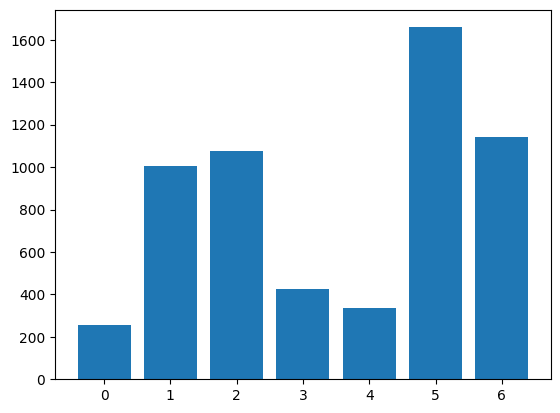

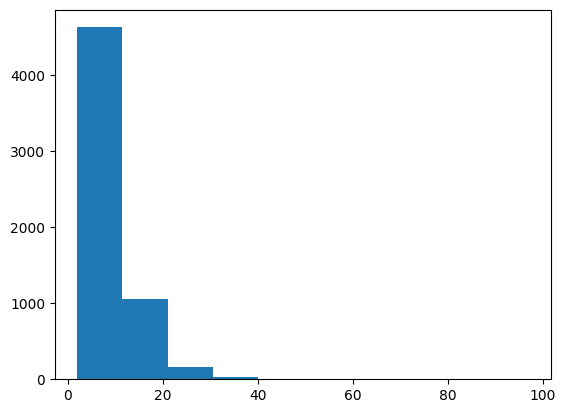

In [30]:
plt.bar(new_train_frame['Emotion'].value_counts().index, new_train_frame['Emotion'].value_counts().values)
plt.show()
plt.hist(new_train_frame['Text'].apply(len))
plt.show()

Phương pháp random undersampling: Giảm tỷ lệ mẫu dữ liệu thuộc một cảm xúc cụ thể trong tập huấn luyện (train) và sau đó chuyển một phần dữ liệu bị loại bỏ sang tập kiểm tra (test)

Thực hiện undersampling với các mẫu có nhãn là Enjoyment vì nhãn này xuất hiện nhiều nhất trong tập train

In [31]:
drop_lst = []
for i in new_train_frame.index[new_train_frame['Emotion']==emotion_to_num['Enjoyment']]:
  if np.random.uniform(0,1)<0.4: # random dưới 40% mẫu trong tập train có nhãn là 'Enjoyment'
    drop_lst.append(i)

drop_df = new_train_frame[new_train_frame.index.isin(drop_lst)]
train_df = new_train_frame.drop(new_train_frame.index[drop_lst])
test_df = pd.concat([test,drop_df])

In [32]:
duplicate = new_train_frame[
    (new_train_frame['Emotion']==emotion_to_num['Anger']) |
    (new_train_frame['Emotion']==emotion_to_num['Fear']) |
    (new_train_frame['Emotion']==emotion_to_num['Surprise'])
]
train_df = pd.concat([train_df,duplicate,duplicate])

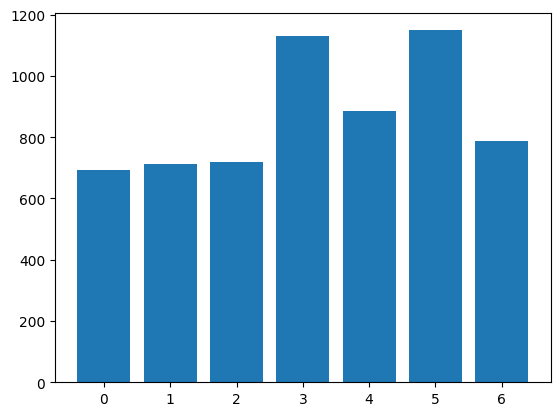

In [33]:
plt.bar(train_df['Emotion'].value_counts().index, train_df['Emotion'].value_counts().values)
plt.show()

Data cân bằng hơn

In [34]:
train_df

,Emotion,Text
188,2,"[_s_, nhạc, _e_]"
166,6,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,6,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
1220,3,"[_s_, thằng, kia, mày, bắt, vợ, bồ, tao, dọn, ..."
1249,3,"[_s_, ,, đau, huống, ., phẫn_nộ, ., cơ_quan_ch..."
...,...,...
324,4,"[_s_, đừng, giận, kia, thằng, sẵn_sàng, dỗ_dàn..."
329,3,"[_s_, đụ_mẹ, mày, con_gái, ,, _unk_, _beaming_..."
337,3,"[_s_, per, suốt, _unk_, người_ta, đi, tập, gym..."
339,4,"[_s_, mới_đầu, mày, vui, ,, _unk_, mày, ?, _e_]"


In [35]:
test_df.shape

(2846, 3)

# Word2Vec

training Word2Vec

In [36]:
model = gensim.models.Word2Vec(corpus,vector_size=100, window=5, min_count=1, workers=4,epochs=100)

In [38]:
# Lưu model word2vec vào file pickle
with open(folder + '/word2vec_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# key_to_index = model.wv.key_to_index
# index_to_key = model.wv.index_to_key

In [40]:
def get_sentence_vector(sentence):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return [0] * model.vector_size  # Trả về vector 0 nếu không có từ nào trong mô hình

# Áp dụng hàm cho toàn bộ cột 'processed_text' để có được vector cho mỗi câu
train_df['vector'] = train_df['Text'].apply(get_sentence_vector)
test_df['vector'] = test_df['Text'].apply(get_sentence_vector)

In [63]:
X = np.vstack(train_df['vector'].values)
y = train_df['Emotion']

X_test_data = np.vstack(test_df['vector'].values)

Tối ưu hóa siêu tham số của Logistic Regression và SVM dùng k-fold cross validation (Word2Vec)

In [42]:
# Số folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Tối ưu tham số
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Lưu kết quả
best_params = {}
results = {}

# Logistic Regression
print("Tuning Logistic Regression...")
best_accuracy_lr = 0
for C in param_grid_lr['C']:
    accuracies = []
    for train_index, val_index in kf.split(X):
        # Chia dữ liệu train/test
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model = LogisticRegression(C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

    # Lưu tham số tốt nhất
    mean_acc = np.mean(accuracies)
    if mean_acc > best_accuracy_lr:
        best_accuracy_lr = mean_acc
        best_params['Logistic Regression'] = {'C': C}

print(f"Best Logistic Regression params: {best_params['Logistic Regression']}")
print(f"Accuracy: {best_accuracy_lr:.4f}")

# SVM
print("\nTuning SVM...")
best_accuracy_svm = 0
for C in param_grid_svm['C']:
    for kernel in param_grid_svm['kernel']:
        accuracies = []
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/test
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Train model
            model = SVC(C=C, kernel=kernel)
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            accuracies.append(acc)

        # Lưu tham số tốt nhất
        mean_acc = np.mean(accuracies)
        if mean_acc > best_accuracy_svm:
            best_accuracy_svm = mean_acc
            best_params['SVM'] = {'C': C, 'kernel': kernel}

print(f"Best SVM params: {best_params['SVM']}")
print(f"Accuracy: {best_accuracy_svm:.4f}")

Tuning Logistic Regression...
Best Logistic Regression params: {'C': 1}
Accuracy: 0.5132

Tuning SVM...
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.6657


In [48]:
# Train the best Logistic Regression model on the entire training data
best_lr_model = LogisticRegression(C=best_params['Logistic Regression']['C'], max_iter=1000)
best_lr_model.fit(X, y)

# Predict on the test data
y_test_pred_lr = best_lr_model.predict(X_test_data)

# Evaluate the model
print('Logistic Regression (Word2Vec)\n')
print(classification_report(test_df['Emotion'], y_test_pred_lr))


# Train the best svm model on the entire training data
best_svm_model = SVC(C=best_params['SVM']['C'], kernel=best_params['SVM']['kernel'])
best_svm_model.fit(X, y)

# Predict on the test data
y_test_pred_svm = best_svm_model.predict(X_test_data)

# Evaluate the model
print()
print('SVM (Word2Vec)\n')
print(classification_report(test_df['Emotion'], y_test_pred_svm))

Logistic Regression (Word2Vec)

              precision    recall  f1-score   support

           0       0.23      0.52      0.32       119
           1       0.68      0.52      0.59       424
           2       0.40      0.25      0.31       511
           3       0.28      0.67      0.40       189
           4       0.39      0.63      0.48       177
           5       0.67      0.64      0.66       921
           6       0.50      0.31      0.38       505

    accuracy                           0.49      2846
   macro avg       0.45      0.51      0.45      2846
weighted avg       0.53      0.49      0.49      2846


SVM (Word2Vec)

              precision    recall  f1-score   support

           0       0.43      0.82      0.56       119
           1       0.77      0.71      0.74       424
           2       0.66      0.53      0.59       511
           3       0.63      0.85      0.72       189
           4       0.69      0.81      0.75       177
           5       0.80      

In [49]:
with open(folder + '/logistic_w2v.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

with open(folder + '/svm_w2v.pkl', 'wb') as file:
    pickle.dump(best_svm_model, file)

Maxent (Word2Vec)

In [52]:
# Chuẩn bị dữ liệu
def format_data_for_maxent(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].tolist())  # Chuyển sang tuple
        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

In [53]:
# Train the best Maxent model on the entire training data
formatted_data = format_data_for_maxent(X, y)

maxent_model = MaxentClassifier.train(formatted_data, algorithm='iis', max_iter=10, trace=0)

# Predict on the test data
X_test_data = np.vstack(test_df['vector'].values)
y_test_pred_maxent = [maxent_model.classify({'features': tuple(vector.tolist())}) for vector in X_test_data]

# Evaluate the model
print(classification_report(test_df['Emotion'], y_test_pred_maxent))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       119
           1       1.00      0.50      0.67       424
           2       0.99      0.47      0.64       511
           3       0.99      0.79      0.88       189
           4       0.96      0.73      0.83       177
           5       0.99      0.54      0.70       921
           6       0.33      0.99      0.50       505

    accuracy                           0.64      2846
   macro avg       0.87      0.68      0.71      2846
weighted avg       0.87      0.64      0.67      2846



In [54]:
with open(folder + '/maxent_w2v.pkl', 'wb') as file:
    pickle.dump(maxent_model, file)

# TF-IDF

In [55]:
# Các tham số để thử nghiệm
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Khởi tạo k-fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Hàm thực hiện k-fold cross-validation với TF-IDF vectorizer
def cross_validate_with_tfidf(model, params, X_raw, y, kf):
    best_params = None
    best_score = 0
    results = []

    for param in params:
        scores = []

        # K-fold cross-validation
        for train_index, val_index in kf.split(X_raw):
            # Tách dữ liệu train/test theo fold
            X_train_raw = [X_raw[i] for i in train_index]
            X_val_raw = [X_raw[i] for i in val_index]
            y_train = y.iloc[train_index]
            y_val = y.iloc[val_index]

            # Áp dụng TF-IDF vectorizer trên tập train và test trong fold này
            vectorizer = TfidfVectorizer()
            X_train = vectorizer.fit_transform([' '.join(text) for text in X_train_raw])
            X_val = vectorizer.transform([' '.join(text) for text in X_val_raw])

            # Cập nhật tham số cho model
            model.set_params(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))

        # Tính điểm trung bình cho bộ tham số
        avg_score = np.mean(scores)
        results.append((param, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = param

    return best_params, best_score, results


# Chuẩn bị dữ liệu
X_raw = train_df['Text'].tolist()
y = train_df['Emotion']

# Logistic Regression
lr_params = [{'C': c} for c in param_grid_lr['C']]
lr_model = LogisticRegression(max_iter=1000)
print("Tuning Logistic Regression...")
best_params_lr, best_score_lr, results_lr = cross_validate_with_tfidf(lr_model, lr_params, X_raw, y, kf)
print(f"Best Logistic Regression params: {best_params_lr}")
print(f"Accuracy: {best_score_lr}")

# SVM
svm_params = [{'C': c, 'kernel': k} for c in param_grid_svm['C'] for k in param_grid_svm['kernel']]
svm_model = SVC()
print("\nTuning SVM...")
best_params_svm, best_score_svm, results_svm = cross_validate_with_tfidf(svm_model, svm_params, X_raw, y, kf)
print(f"Best SVM params: {best_params_svm}")
print(f"Accuracy: {best_score_svm}")

Best Logistic Regression params: {'C': 10}, Score: 0.703405755902101
Best SVM params: {'C': 10, 'kernel': 'rbf'}, Score: 0.7316994260342213


In [56]:
# Khởi tạo TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

In [58]:
# Train the best Logistic Regression model on the entire training data
best_lr_model = LogisticRegression(C=best_params_lr['C'], max_iter=1000)
best_lr_model.fit(X_train_tfidf, y)

# Predict on the test data
y_test_pred_tf_lr = best_lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression (TF-IDF) - Best Model:")
print(classification_report(test_df['Emotion'], y_test_pred_tf_lr))


# Train the best SVM model on the entire training data
best_svm_model = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'])
best_svm_model.fit(X_train_tfidf, y)

# Predict on the test data
y_test_pred_tf_svm = best_svm_model.predict(X_test_tfidf)

# Evaluate the model
print("\nSVM (TF-IDF) - Best Model:")
print(classification_report(test_df['Emotion'], y_test_pred_tf_svm))

Logistic Regression (TF-IDF) - Best Model:
              precision    recall  f1-score   support

           0       0.52      0.83      0.64       119
           1       0.82      0.76      0.79       424
           2       0.69      0.60      0.64       511
           3       0.62      0.86      0.72       189
           4       0.75      0.92      0.82       177
           5       0.84      0.83      0.83       921
           6       0.79      0.69      0.74       505

    accuracy                           0.76      2846
   macro avg       0.72      0.78      0.74      2846
weighted avg       0.77      0.76      0.76      2846


SVM (TF-IDF) - Best Model:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72       119
           1       0.84      0.77      0.80       424
           2       0.69      0.67      0.68       511
           3       0.81      0.84      0.83       189
           4       0.85      0.90      0.88       177
       

In [59]:
with open(folder + '/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

with open(folder + '/logistic_tfidf.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

with open(folder + '/svm_tfidf.pkl', 'wb') as file:
    pickle.dump(best_svm_model, file)

Maxent (TF-IDF)

In [61]:
# MaxEnt
# Prepare data for MaxentClassifier with TF-IDF features
def format_data_for_maxent_tfidf(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].toarray()[0].tolist())
        # Use .iloc to access the element by position
        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

train_data_tfidf = format_data_for_maxent_tfidf(X_train_tfidf, train_df['Emotion'])
test_data_tfidf = format_data_for_maxent_tfidf(X_test_tfidf, test_df['Emotion'])

maxent_classifier_tfidf = MaxentClassifier.train(train_data_tfidf, trace=0, algorithm='iis', max_iter=10)

predictions_tfidf = [maxent_classifier_tfidf.classify({'features': tuple(vector.toarray()[0].tolist())}) for vector in X_test_tfidf]

print("\nMaxEnt (TF-IDF):")
print(classification_report(test_df['Emotion'], predictions_tfidf))
print("Accuracy:", accuracy(maxent_classifier_tfidf, test_data_tfidf))


MaxEnt (TF-IDF):
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       119
           1       0.99      0.43      0.60       424
           2       0.97      0.40      0.56       511
           3       0.99      0.62      0.77       189
           4       0.96      0.62      0.75       177
           5       0.98      0.48      0.64       921
           6       0.30      0.98      0.46       505

    accuracy                           0.57      2846
   macro avg       0.84      0.60      0.64      2846
weighted avg       0.85      0.57      0.61      2846

Accuracy: 0.573085031623331


In [62]:
with open(folder + '/maxent_tfidf.pkl', 'wb') as file:
    pickle.dump(maxent_classifier_tfidf, file)